<a href="https://colab.research.google.com/github/timnll/ProjetBigData/blob/master/NYC_Taxi_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA**

### *Import librairies*

In [0]:
from __future__ import print_function

import pandas as pd
import numpy as np
import yaml
import time, datetime
import os.path, sys
from matplotlib.pyplot import figure

# MatPlotLib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Import data

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1bJbQgQae2zuWdeN4J-v67YNmFRdaxCph' #shareable link

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('yellow_tripdata_2019-01.csv')  
datas_2019_01 = pd.read_csv('yellow_tripdata_2019-01.csv')
# Dataset is now stored in a Pandas Dataframe
print (datas_2019_01)

1bJbQgQae2zuWdeN4J-v67YNmFRdaxCph
         VendorID tpep_pickup_datetime  ... total_amount  congestion_surcharge
0               1  2019-01-01 00:46:40  ...         9.95                   NaN
1               1  2019-01-01 00:59:47  ...        16.30                   NaN
2               2  2018-12-21 13:48:30  ...         5.80                   NaN
3               2  2018-11-28 15:52:25  ...         7.55                   NaN
4               2  2018-11-28 15:56:57  ...        55.55                   NaN
5               2  2018-11-28 16:25:49  ...        13.31                   NaN
6               2  2018-11-28 16:29:37  ...        55.55                   NaN
7               1  2019-01-01 00:21:28  ...         9.05                   NaN
8               1  2019-01-01 00:32:01  ...        18.50                   NaN
9               1  2019-01-01 00:57:32  ...        13.00                   NaN
10              1  2019-01-01 00:24:04  ...        19.55                   NaN
11              1 

### *Clean data*

In [0]:
runs_2019_01 = datas_2019_01.copy()
runs_2019_01.columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge']

useless_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge']
runs_2019_01 = runs_2019_01.drop(columns=useless_columns)
runs_2019_01['tpep_pickup_datetime'] = pd.to_datetime(runs_2019_01['tpep_pickup_datetime'])
runs_2019_01['tpep_dropoff_datetime'] = pd.to_datetime(runs_2019_01['tpep_dropoff_datetime'])
runs_2019_01
#print(runs_2019_01)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.50,151,239,1,7.0,0.5,0.5,1.65,0.00,0.3,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.60,239,246,1,14.0,0.5,0.5,1.00,0.00,0.3,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.00,236,236,1,4.5,0.5,0.5,0.00,0.00,0.3,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.00,193,193,2,3.5,0.5,0.5,0.00,0.00,0.3,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.00,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55
5,2018-11-28 16:25:49,2018-11-28 16:28:26,5,0.00,193,193,2,3.5,0.5,0.5,0.00,5.76,0.3,13.31
6,2018-11-28 16:29:37,2018-11-28 16:33:43,5,0.00,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.30,163,229,1,6.5,0.5,0.5,1.25,0.00,0.3,9.05
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.70,229,7,1,13.5,0.5,0.5,3.70,0.00,0.3,18.50
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.10,141,234,1,10.0,0.5,0.5,1.70,0.00,0.3,13.00


# **TRAITEMENT**

### *Hour frequency*

Text(0.5,0,'hours')

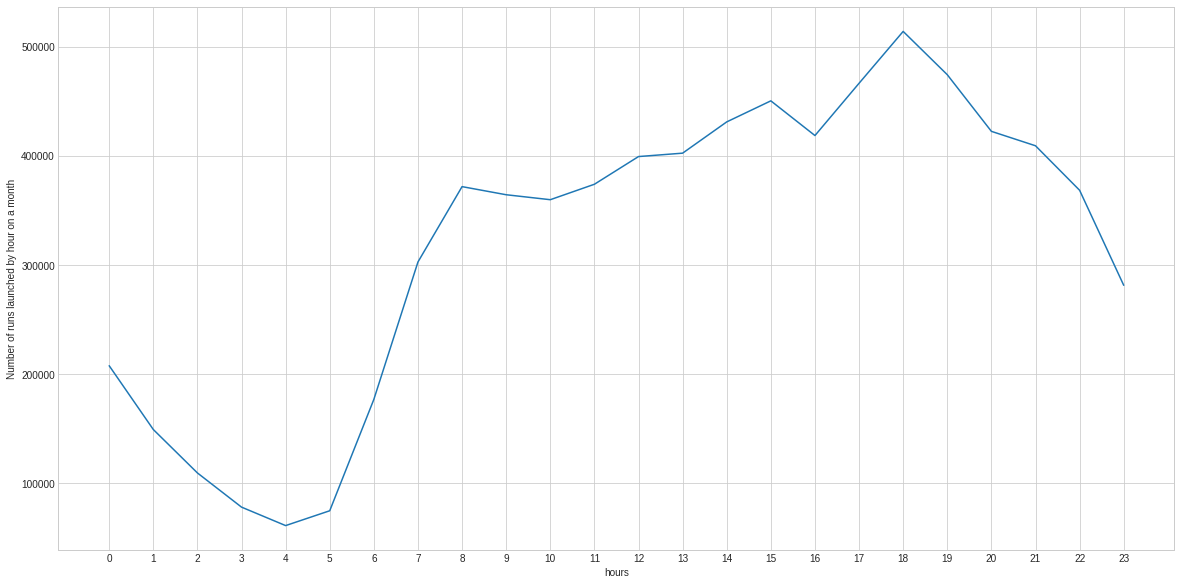

In [0]:
frequency_by_hour = []
runs = []
hour = pd.date_range("00:00", "23:00",freq="1H").time

for hour in hour:
  if hour == datetime.time(23, 0):
      runs = runs_2019_01[runs_2019_01['tpep_pickup_datetime'].dt.time.between(hour, (datetime.datetime.combine(datetime.date(1,1,1),hour) + datetime.timedelta(seconds=3599)).time())]
      frequency_by_hour.append(len(runs))
  else:
    runs = runs_2019_01[runs_2019_01['tpep_pickup_datetime'].dt.time.between(hour, (datetime.datetime.combine(datetime.date(1,1,1),hour) + datetime.timedelta(hours=1)).time())]
    frequency_by_hour.append(len(runs))

#print(frequency_by_hour)
hours=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] #x label

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(hours,frequency_by_hour)
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.ylabel("Number of runs launched by hour on a month")
plt.xlabel("hours")



### *Average run time*

Text(0.5,0,'time interval in minutes')

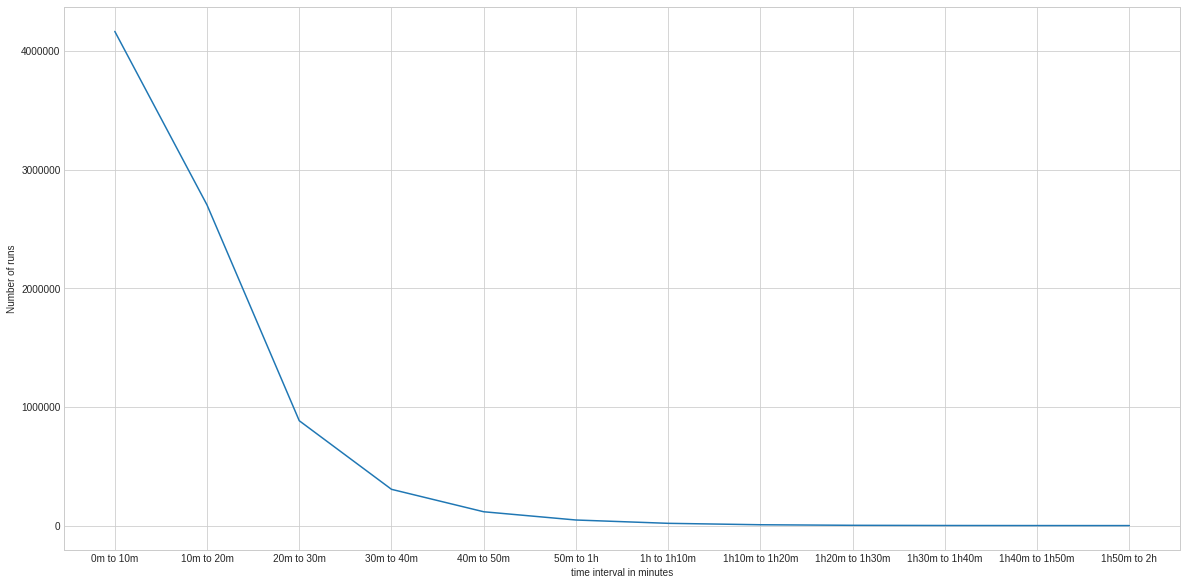

In [0]:
Average_time_run = []
runs = []
time_interval = 10
time_interval_label = [0, 1*time_interval, 2*time_interval,3*time_interval,
                       4*time_interval, 5*time_interval,6*time_interval,
                       7*time_interval, 8*time_interval, 9*time_interval,
                       10*time_interval, 11*time_interval]

for interval in time_interval_label:
  runs = runs_2019_01[(runs_2019_01['tpep_dropoff_datetime'] - runs_2019_01['tpep_pickup_datetime']).astype('timedelta64[m]').between(interval, interval + time_interval)]
  Average_time_run.append(len(runs))

#print(Average_time_run)

plt.figure(figsize=(20,10))
ax = plt.axes()
x_label = ["0m to 10m", "10m to 20m", "20m to 30m", "30m to 40m", "40m to 50m", "50m to 1h", "1h to 1h10m", "1h10m to 1h20m", "1h20m to 1h30m", "1h30m to 1h40m", "1h40m to 1h50m", "1h50m to 2h"]
ax.plot(x_label,Average_time_run)
plt.ylabel("Number of runs")
plt.xlabel("time interval in minutes")